In [23]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
import numpy as np 
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

In [66]:
predictions_xgb_2022 = pd.read_csv(r'C:\Users\elif.yozkan\Desktop\customer-retention-advantech\predictions\predictions_XGB_2022.csv')
predictions_mlp_2022 = pd.read_csv(r'C:\Users\elif.yozkan\Desktop\customer-retention-advantech\predictions\predictions_MLP_2022.csv')
predictions_xgb_2023 = pd.read_csv(r'C:\Users\elif.yozkan\Desktop\customer-retention-advantech\predictions\predictions_XGB_2023.csv')
predictions_mlp_2023 = pd.read_csv(r'C:\Users\elif.yozkan\Desktop\customer-retention-advantech\predictions\predictions_MLP_2023.csv')

In [25]:
def get_predictions(df): 

    correct_preds_0 = df.loc[(df['target_encoded'] == 0)&(df['Predictions']==0)]
    correct_preds_1 = df.loc[(df['target_encoded'] == 1)&(df['Predictions']==1)]

    incorrect_preds_0 = df.loc[(df['target_encoded'] == 1)&(df['Predictions']==0)]
    incorrect_preds_1 = df.loc[(df['target_encoded'] == 0)&(df['Predictions']==1)]

    return correct_preds_0,correct_preds_1,incorrect_preds_0,incorrect_preds_1

    

In [26]:
def get_predictions_customertype(df): 

    correct_preds_0 = df.loc[(df['target_encoded'] == 0)&(df['Predictions']==0)]
    correct_preds_1 = df.loc[(df['target_encoded'] == 1)&(df['Predictions']==1)]

    incorrect_preds_0 = df.loc[(df['target_encoded'] == 1)&(df['Predictions']==0)]
    incorrect_preds_1 = df.loc[(df['target_encoded'] == 0)&(df['Predictions']==1)]

    return correct_preds_0,correct_preds_1,incorrect_preds_0,incorrect_preds_1

In [27]:
def analyze_probs(correct_preds_0,correct_preds_1,incorrect_preds_0,incorrect_preds_1,mlp=False):
    if(mlp):
        correct_preds_0 = correct_preds_0['Probability_Class_0']
        correct_preds_1 = correct_preds_1['Probability_Class_1']
        incorrect_preds_0 = incorrect_preds_0['Probability_Class_0']
        incorrect_preds_1 = incorrect_preds_1['Probability_Class_1']
    else:
        correct_preds_0 = correct_preds_0['Probability']
        correct_preds_1 = correct_preds_1['Probability']
        incorrect_preds_0 = incorrect_preds_0['Probability']
        incorrect_preds_1 = incorrect_preds_1['Probability']

    print("Mean Probability for Correct Predictions (Class 0 ) : " + str(correct_preds_0.mean()))
    print('Std : ' +str(correct_preds_0.std()) )
    print()

    print("Mean Probability for Correct Predictions (Class 1 ) : " + str(correct_preds_1.mean()))
    print('Std : ' +str(correct_preds_1.std()) )
    print()

    print("Mean Probability for Incorrect Predictions (Class 0 ) : " + str(incorrect_preds_0.mean()))
    print('Std : ' +str(incorrect_preds_0.std()) )
    print()

    print("Mean Probability for Incorrect Predictions (Class 1) : " + str(incorrect_preds_1.mean()))
    print('Std : ' +str(incorrect_preds_1.std()) )
    print()

In [28]:
correct_xgb_0_2023, correct_xgb_1_2023, incorrect_xgb_0_2023,incorrect_xgb_1_2023 = get_predictions(predictions_xgb_2023)
print("XGB 2023")
analyze_probs(correct_xgb_0_2023, correct_xgb_1_2023, incorrect_xgb_0_2023,incorrect_xgb_1_2023)

XGB 2023
Mean Probability for Correct Predictions (Class 0 ) : 0.8725602497311106
Std : 0.1435536738969044

Mean Probability for Correct Predictions (Class 1 ) : 0.8683804280077183
Std : 0.09450259764654796

Mean Probability for Incorrect Predictions (Class 0 ) : 0.6842426286666667
Std : 0.09976307908464213

Mean Probability for Incorrect Predictions (Class 1) : 0.7242513757543594
Std : 0.12883284657505173



In [29]:
correct_xgb_0_2022, correct_xgb_1_2022, incorrect_xgb_0_2022,incorrect_xgb_1_2022 = get_predictions(predictions_xgb_2022)
print("XGB 2022")
analyze_probs(correct_xgb_0_2022, correct_xgb_1_2022, incorrect_xgb_0_2022,incorrect_xgb_1_2022)

XGB 2022
Mean Probability for Correct Predictions (Class 0 ) : 0.8738023673787313
Std : 0.12382873862507322

Mean Probability for Correct Predictions (Class 1 ) : 0.8965768954266422
Std : 0.09703260943812139

Mean Probability for Incorrect Predictions (Class 0 ) : 0.5524819354237289
Std : 0.04452373184869573

Mean Probability for Incorrect Predictions (Class 1) : 0.8067716059062283
Std : 0.12430306459326222



In [30]:
def compute_euclidean_dist(prediction_df,mlp=False):

    prediction_df['incorrect_prediction'] = (prediction_df['Predictions'] != prediction_df['target_encoded'])
    if mlp: 
        X =prediction_df.drop(['Label','Customer_Id','target_encoded','Predictions','Probability_Class_0','Probability_Class_1','incorrect_prediction'],axis=1)
    else:
        X = prediction_df.drop(['Label','Customer_Id','target_encoded','Predictions','Probability','incorrect_prediction'],axis=1)

    incorrect_instances = X[prediction_df['incorrect_prediction']]
    correct_instances = X[~prediction_df['incorrect_prediction']]

    # Calculate Euclidean distances between incorrect instances and correct instances
    euclidean_distances = np.empty((len(incorrect_instances), len(correct_instances)))
    for i, incorrect_row in enumerate(incorrect_instances.values):
        for j, correct_row in enumerate(correct_instances.values):
            distance = np.linalg.norm(incorrect_row - correct_row)
            euclidean_distances[i, j] = distance


    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    reduced_distances = pca.fit_transform(euclidean_distances)

    # Create a scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(reduced_distances[:, 0], reduced_distances[:, 1], c='blue', alpha=0.5)
    plt.title('Scatter Plot of Euclidean Distances')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

### Plot Euclidean Distances between Incorrectly and Correctly Identified Instances for 2022 Predictions

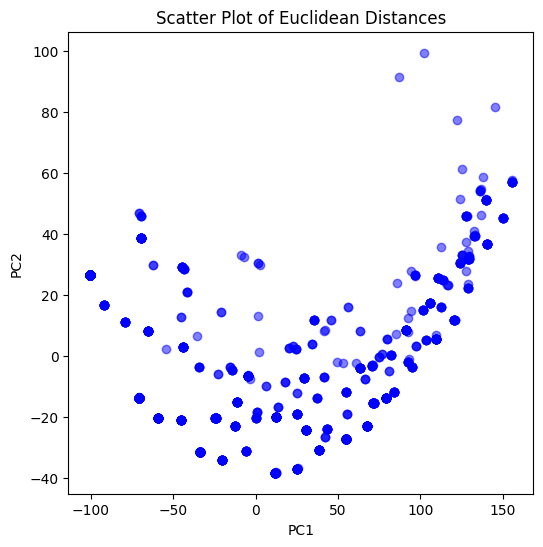

In [31]:
compute_euclidean_dist(predictions_xgb_2022)

### Plot Euclidean Distances between Incorrectly and Correctly Identified Instances for 2023 Predictions

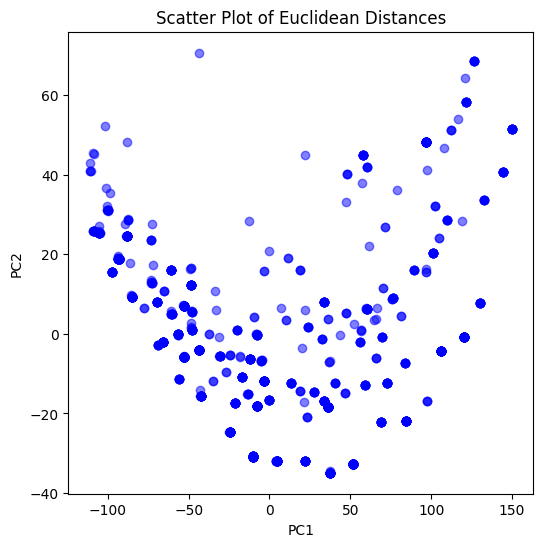

In [32]:
compute_euclidean_dist(predictions_xgb_2023)

### Plot Euclidean Distances between Incorrectly and Correctly Identified Instances for 2023 Predictions (MLP)

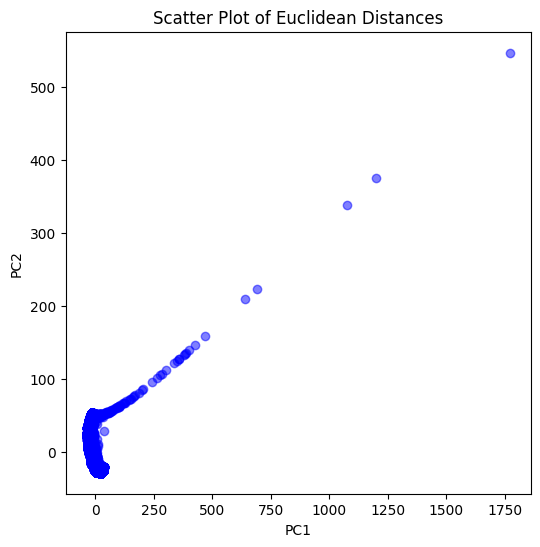

In [33]:
compute_euclidean_dist(predictions_mlp_2023,mlp=True)

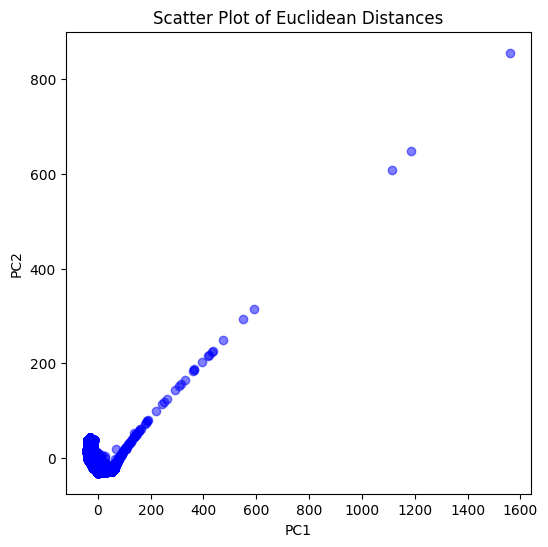

In [34]:
compute_euclidean_dist(predictions_mlp_2022,mlp=True)

In [35]:
def t_test(incorrect_class,correct_class):
    # List of features to test
    features_to_test = ['RFM_Score', 'Frequency_Score', 'Monetary_Score', 'qty']

    # Perform t-test for each feature
    p_values = []
    for feature in features_to_test:
        t_stat, p_value = ttest_ind(incorrect_class[feature], correct_class[feature])
        p_values.append(p_value)

    # Apply Bonferroni correction
    alpha = 0.05
    reject, corrected_p_values, _, _ = multipletests(p_values, alpha=alpha, method='bonferroni')

    # List features that have significant differences
    significant_features = [features_to_test[i] for i in range(len(features_to_test)) if reject[i]]
    print("Features with significant differences:", significant_features)

In [36]:
correct_mlp_0_2022, correct_mlp_1_2022, incorrect_mlp_0_2022,incorrect_mlp_1_2022 = get_predictions(predictions_mlp_2022)
correct_mlp_0_2023, correct_mlp_1_2023, incorrect_mlp_0_2023,incorrect_mlp_1_2023 = get_predictions(predictions_mlp_2023)

In [18]:

print("Class 0 (churn)")
print("Features with significant differences: ['RFM_Score', 'Monetary_Score','Opportunity_Amt']")
print()
print("Class 1 (retain)")
print("Features with significant differences: ['RFM_Score', 'Monetary_Score','Opportunity_Amt','Backlog','Frequency_Score','qty']")

Class 0 (churn)
Features with significant differences: ['RFM_Score', 'Monetary_Score','Opportunity_Amt']

Class 1 (retain)
Features with significant differences: ['RFM_Score', 'Monetary_Score','Opportunity_Amt','Backlog','Frequency_Score','qty']


In [38]:
print("Predictions for 2023")
print("Class 0 (churn)")
t_test(incorrect_xgb_0_2023,correct_xgb_0_2023)
print()
print("Class 1 (retain)")
t_test(incorrect_xgb_1_2023,correct_xgb_1_2023)

Predictions for 2023
Class 0 (churn)
Features with significant differences: ['RFM_Score']

Class 1 (retain)
Features with significant differences: ['RFM_Score', 'Frequency_Score', 'Monetary_Score', 'qty']


In [39]:
print("Predictions for 2023 (MLP)")
print("Class 0 (churn)")
t_test(incorrect_mlp_0_2023,correct_mlp_0_2023)
print()
print("Class 1 (retain)")
t_test(incorrect_mlp_1_2023,correct_mlp_1_2023)

Predictions for 2023 (MLP)
Class 0 (churn)
Features with significant differences: ['RFM_Score', 'qty']

Class 1 (retain)
Features with significant differences: ['RFM_Score', 'Frequency_Score', 'Monetary_Score']


In [40]:
# Create a box plot for RFM scores
def box_plot(incorrect,correct):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    
    axes[0].boxplot([incorrect['RFM_Score'], correct['RFM_Score']],
                labels=['Incorrectly Classified as Retain', 'Correctly Classified'])
    axes[0].set_title('RFM Score Distribution')
    axes[0].set_ylabel('RFM Score')
    
    axes[1].boxplot([incorrect['Frequency_Score'], correct['Frequency_Score']],
                labels=['Incorrectly Classified', 'Correctly Classified'])
    axes[1].set_title('Frequency_Score Distribution')
    axes[1].set_ylabel('Frequency_Score')

    axes[2].boxplot([incorrect['Monetary_Score'], correct['Monetary_Score']],
                labels=['Incorrectly Classified', 'Correctly Classified'])
    axes[2].set_title('Monetary_Score Distribution')
    axes[2].set_ylabel('Monetary_Score')

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()

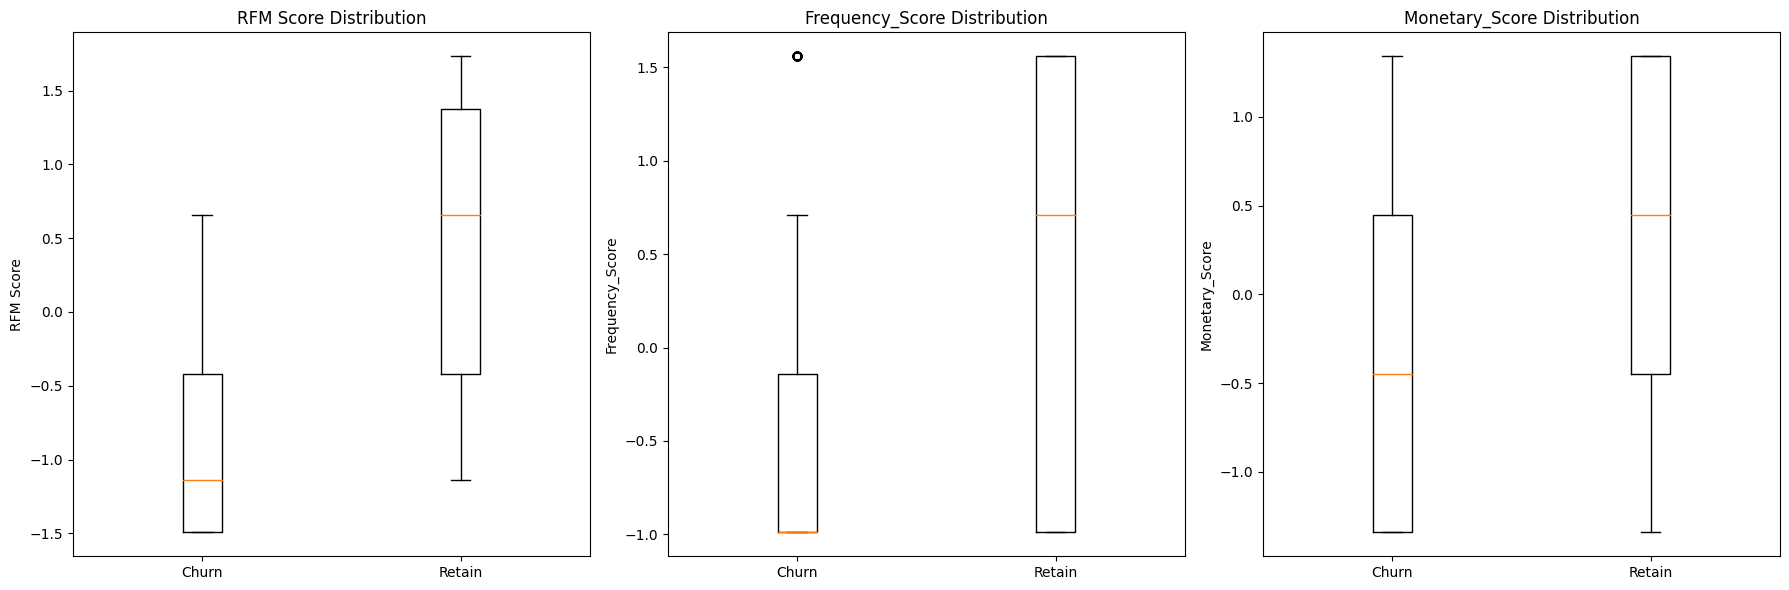

In [41]:
 fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    
axes[0].boxplot([correct_xgb_0_2022['RFM_Score'], correct_xgb_1_2022['RFM_Score']],
                labels=['Churn', 'Retain'])
axes[0].set_title('RFM Score Distribution')
axes[0].set_ylabel('RFM Score')

axes[1].boxplot([correct_xgb_0_2022['Frequency_Score'], correct_xgb_1_2022['Frequency_Score']],
                labels=['Churn', 'Retain'])
axes[1].set_title('Frequency_Score Distribution')
axes[1].set_ylabel('Frequency_Score')

axes[2].boxplot([correct_xgb_0_2022['Monetary_Score'], correct_xgb_1_2022['Monetary_Score']],
                labels=['Churn', 'Retain'])
axes[2].set_title('Monetary_Score Distribution')
axes[2].set_ylabel('Monetary_Score')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

### Plot the difference between RFM distributions for false positives - 2022

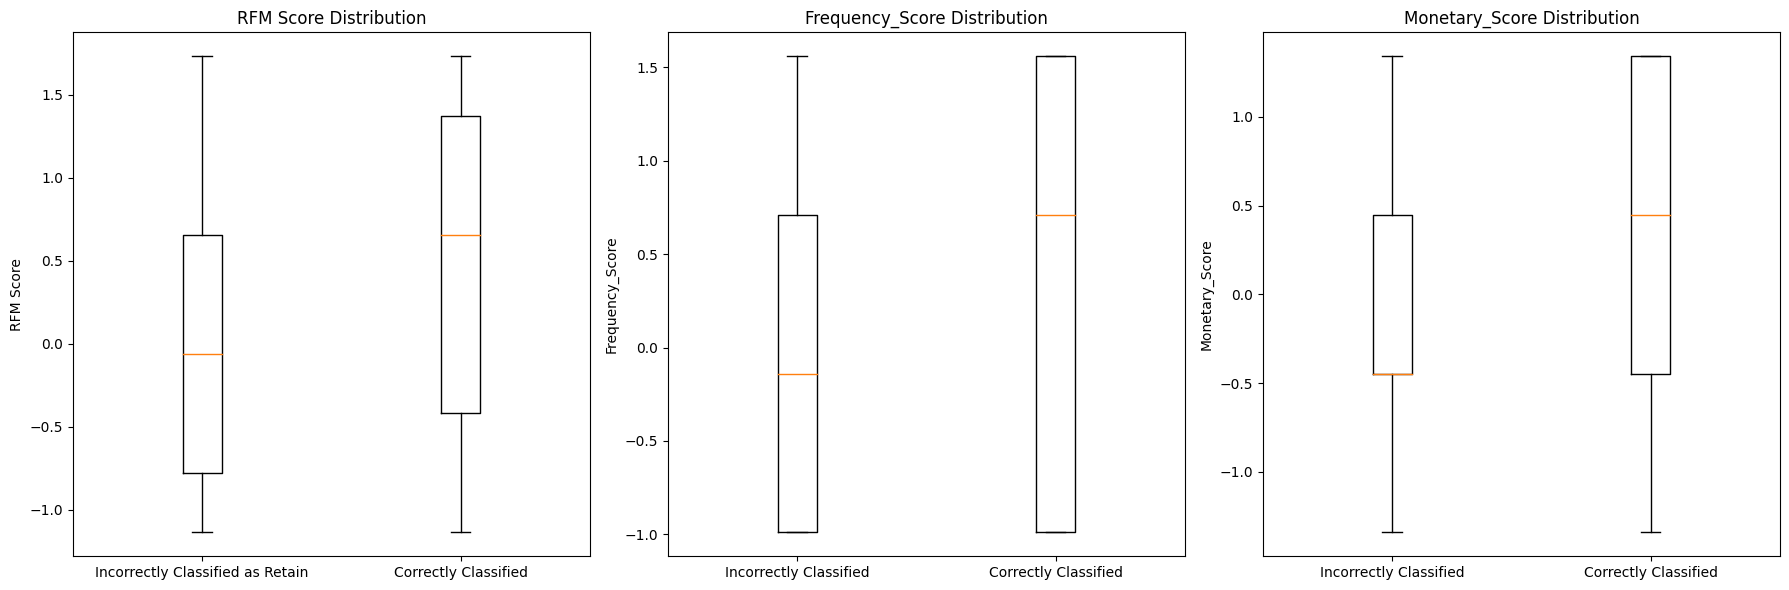

In [42]:
box_plot(incorrect_xgb_1_2022,correct_xgb_1_2022)

### Plot the difference between RFM distributions for false negatives - 2023

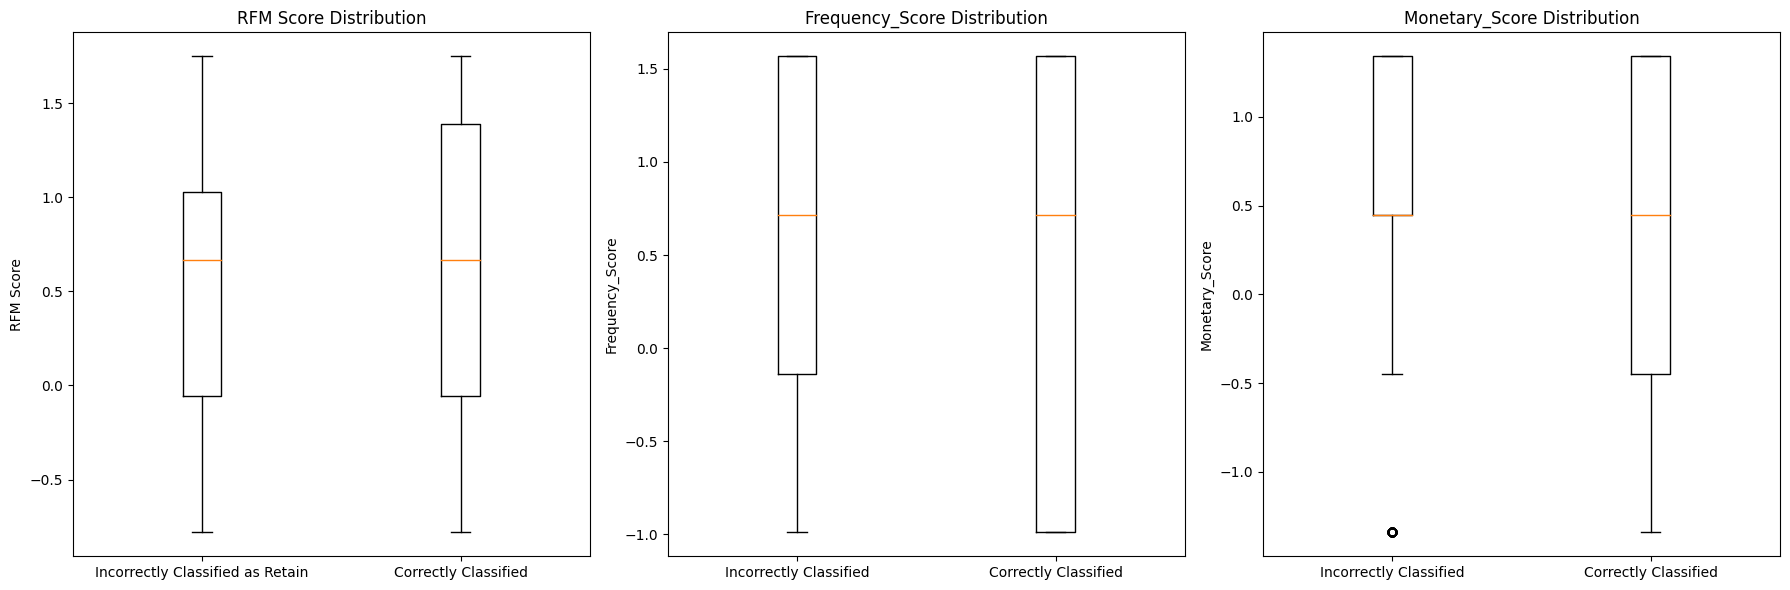

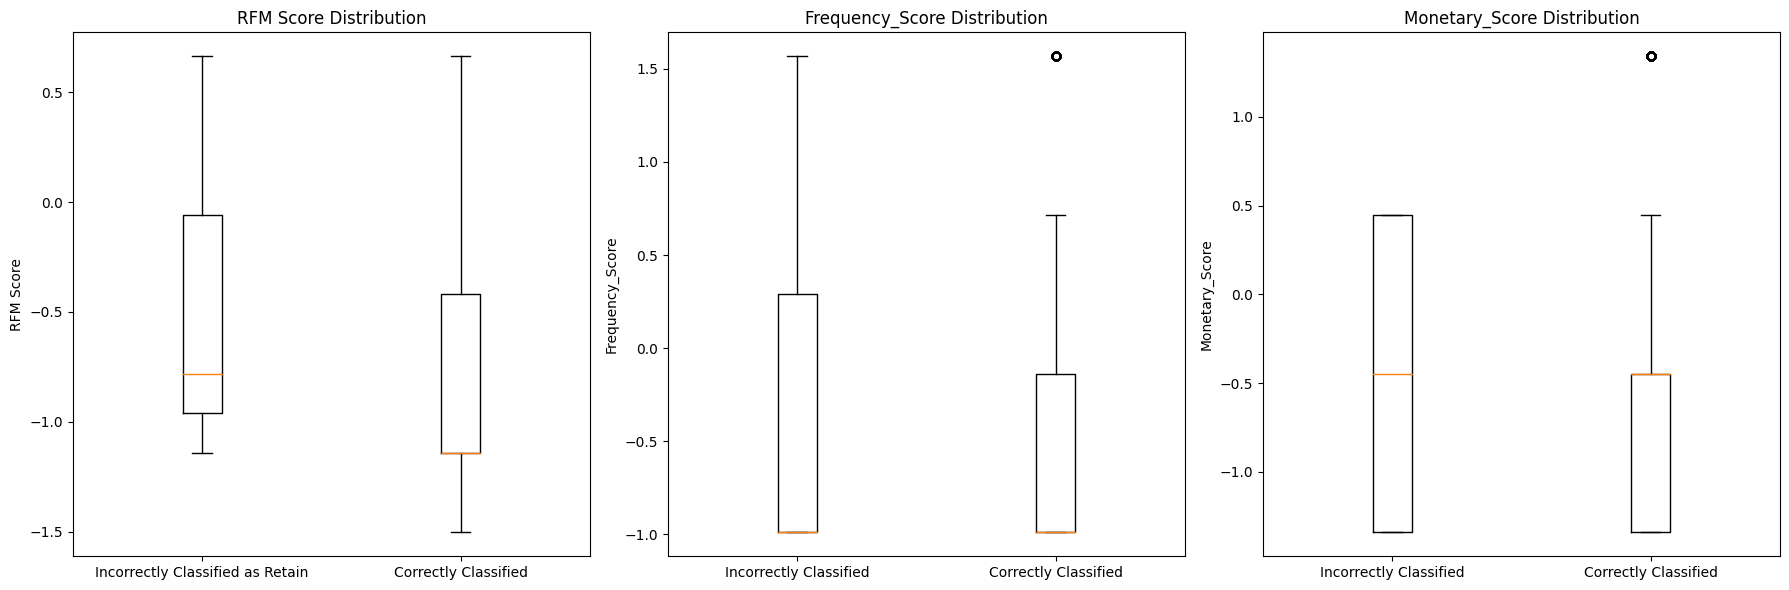

In [43]:
box_plot(incorrect_xgb_1_2023,correct_xgb_1_2023)
box_plot(incorrect_xgb_0_2023,correct_xgb_0_2023)

### Plot the difference between RFM distributions for false negatives (MLP) - 2023

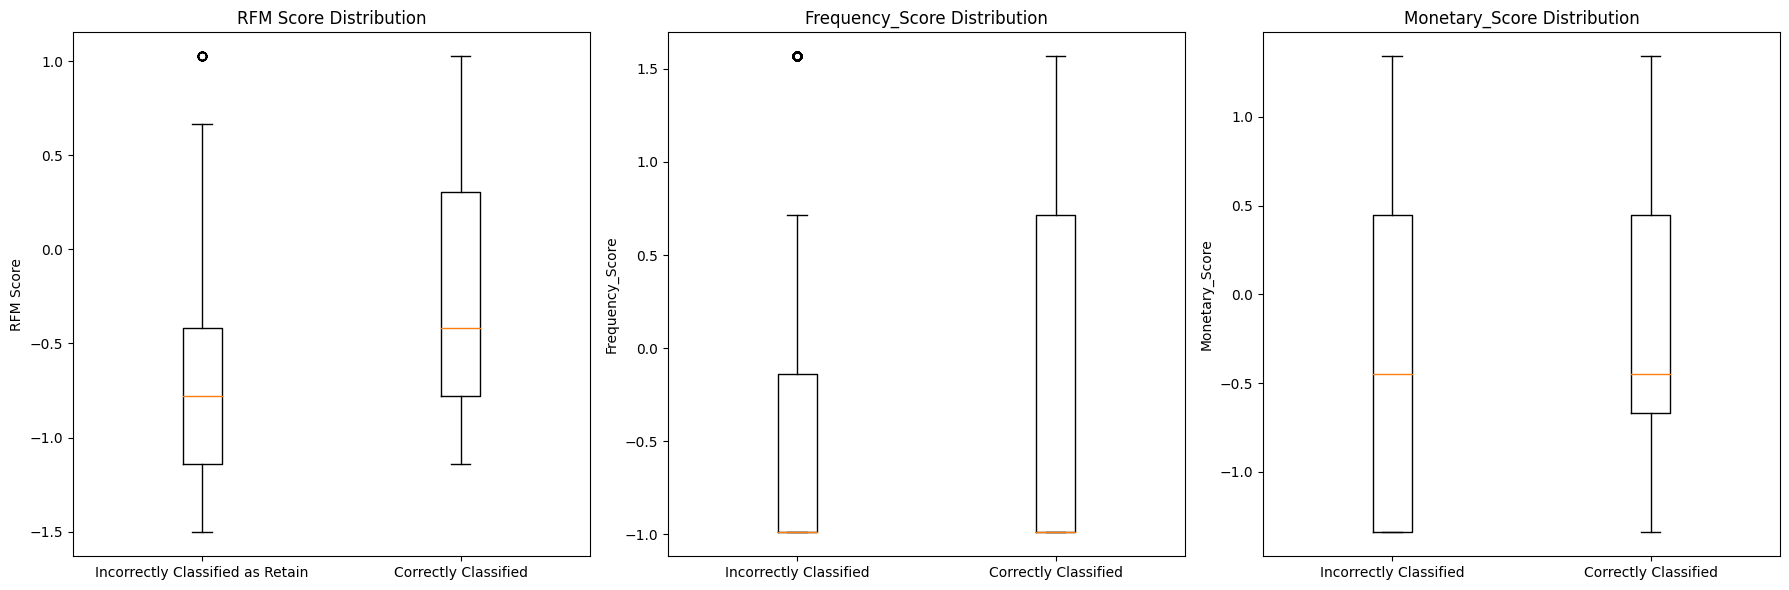

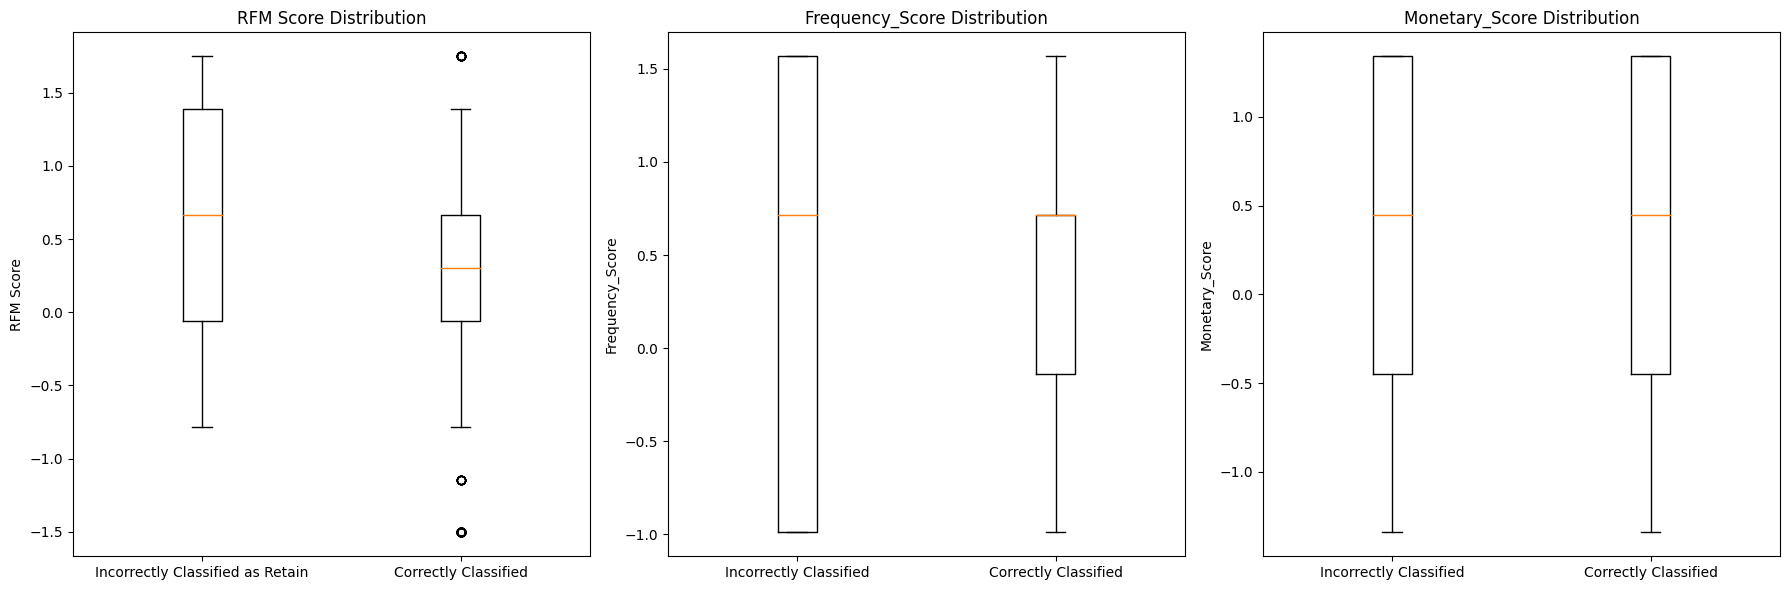

In [44]:
box_plot(incorrect_mlp_1_2023,correct_mlp_1_2023)
box_plot(incorrect_mlp_0_2023,correct_mlp_0_2023)

In [46]:
predictions_xgb_2022.columns

Index(['Frequency_Score', 'Monetary_Score', 'RFM_Score', 'qty', 'Label',
       'Customer_Id', 'Customer Type_AOL', 'Customer Type_CP',
       'Customer Type_KA', 'Customer Type_KA, CP, AOL', 'target_encoded',
       'Predictions', 'Probability', 'incorrect_prediction'],
      dtype='object')

In [63]:
def get_predictions_CT(df):
    cust_type_KA= df.loc[df['Customer Type_KA']]
    cust_type_CP= df.loc[df['Customer Type_CP']]
    cust_type_AOL = df.loc[df['Customer Type_AOL']]

    correct_KA = cust_type_KA.loc[cust_type_KA['target_encoded'] == cust_type_KA['Predictions']]
    correct_CP = cust_type_CP.loc[cust_type_CP['target_encoded'] == cust_type_CP['Predictions']]
    correct_AOL = cust_type_AOL.loc[cust_type_AOL['target_encoded'] == cust_type_AOL['Predictions']]

    incorrect_KA = cust_type_KA.loc[cust_type_KA['target_encoded'] != cust_type_KA['Predictions']]
    incorrect_CP = cust_type_CP.loc[cust_type_CP['target_encoded'] != cust_type_CP['Predictions']]
    incorrect_AOL = cust_type_AOL.loc[cust_type_AOL['target_encoded'] != cust_type_AOL['Predictions']]

    print('Correct & Incorrect Prediction Based on Customer Type ')

    print(f" # Correct Predictions Customer Type KA : {correct_KA.shape[0]}")
    print(f" # Incorrect Predictions Customer Type KA : {incorrect_KA.shape[0]}")
    print()
    print(f" # Correct Predictions Customer Type CP : {correct_CP.shape[0]}")
    print(f" # Incorrect Predictions Customer Type CP : {incorrect_CP.shape[0]}")
    print()
    print(f" # Correct Predictions Customer Type AOL : {correct_AOL.shape[0]}")
    print(f" # Incorrect Predictions Customer Type AOL : {incorrect_AOL.shape[0]}")


    correct_counts = [correct_AOL.shape[0], correct_CP.shape[0], correct_KA.shape[0]]  # Replace with your correct counts
    incorrect_counts = [incorrect_AOL.shape[0], incorrect_CP.shape[0], incorrect_KA.shape[0]]  # Replace with your incorrect counts
    customer_types = ['Customer_Type_AOL', 'Customer_Type_CP', 'Customer_Type_KA']  # Replace with your customer types
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Loop through each customer type and create a pie chart
    for i, customer_type in enumerate(customer_types):
        total_counts = correct_counts[i] + incorrect_counts[i]
        correct_percentage = (correct_counts[i] / total_counts) * 100
        incorrect_percentage = (incorrect_counts[i] / total_counts) * 100
   
        labels = [f'Correct ({correct_percentage:.1f}%)', f'Incorrect ({incorrect_percentage:.1f}%)']
    
        # Create data for the pie chart
        data = [correct_counts[i], incorrect_counts[i]]
    
        # Create the pie chart
        axes[i].pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f'Customer Type: {customer_type}')
    
    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the pie charts
    plt.show()

Correct & Incorrect Prediction Based on Customer Type 
 # Correct Predictions Customer Type KA : 2599
 # Incorrect Predictions Customer Type KA : 531

 # Correct Predictions Customer Type CP : 514
 # Incorrect Predictions Customer Type CP : 90

 # Correct Predictions Customer Type AOL : 4660
 # Incorrect Predictions Customer Type AOL : 578


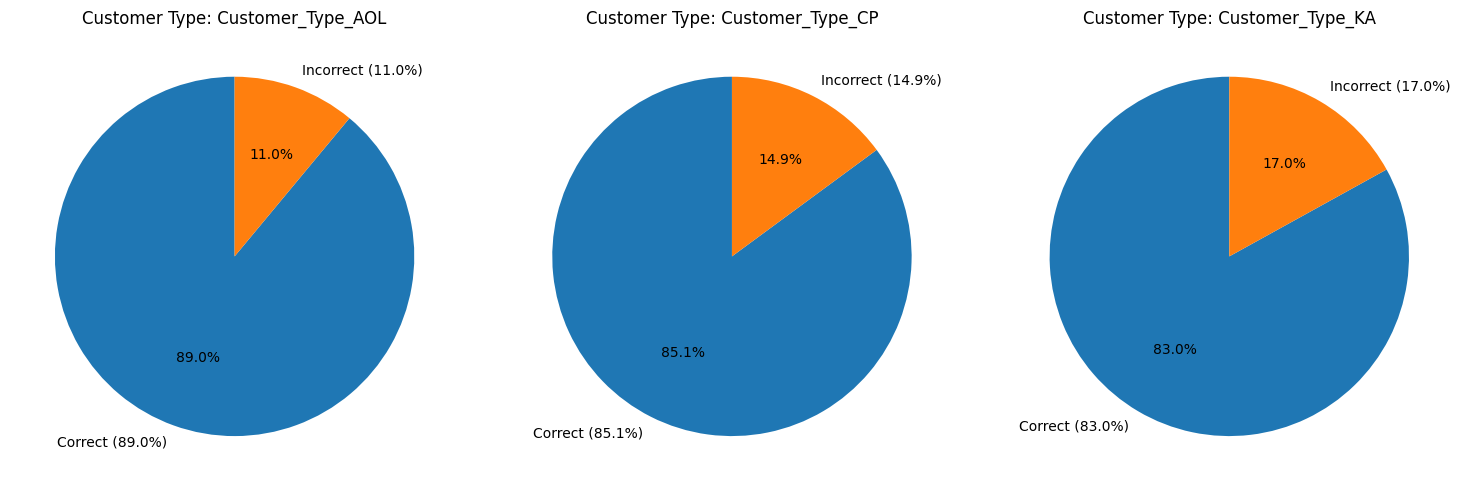

In [67]:
get_predictions_CT(predictions_xgb_2023)

In [8]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_csv(r'C:\Users\elif.yozkan\Desktop\cr-tr.csv')
data

,Frequency_Score,Monetary_Score,RFM_Score,qty,cust_country,Label,Customer_Id,Customer_AOL,Customer_CP,Customer_KA,Opportunity_Amt,Backlog
0,-0.982678,1.341715,0.683157,-0.096468,France,retain,100035,0,0,0,-0.041088,-0.021365
1,-0.982678,-0.447073,-0.058519,-0.100826,Germany,retain,100037,0,0,0,-0.041088,-0.021365
2,-0.982678,-0.447073,-0.058519,-0.100923,Russian Federation,retain,100107,0,1,0,-0.041088,-0.021365
3,-0.982678,-1.341468,-0.429357,-0.100923,Poland,retain,100113,0,0,0,-0.041088,-0.021365
4,-0.133596,0.447321,0.683157,-0.100342,Germany,churn,100153,0,0,0,-0.041088,-0.021365
...,...,...,...,...,...,...,...,...,...,...,...,...
10844,-0.982678,1.341715,-0.058519,-0.088331,USA,churn,UWIGEM003,0,0,1,-0.041088,-0.021365
10845,-0.133596,1.341715,0.683157,0.027806,USA,retain,UWIGEM006,0,0,1,-0.041088,-0.021365
10846,1.564567,1.341715,1.424833,0.191503,USA,churn,UWIGEM018,0,0,1,-0.041088,-0.021365
10847,-0.133596,0.447321,0.312319,-0.100633,Canada,retain,UZCAIMA01,0,0,0,-0.041088,-0.021365


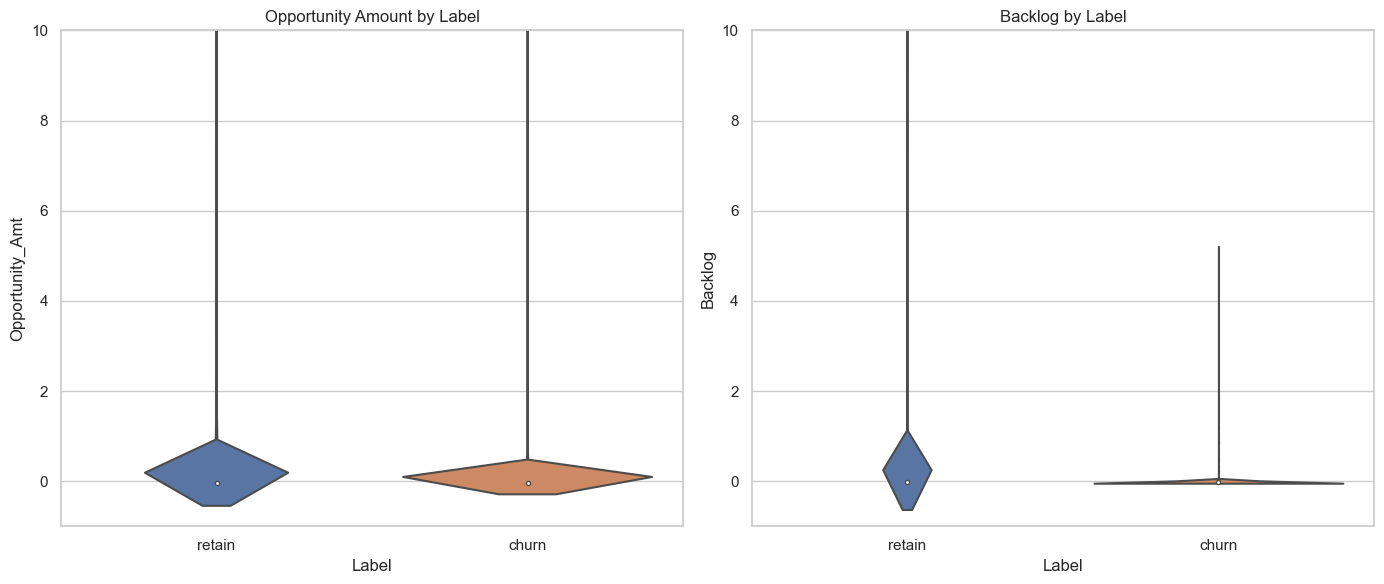

In [10]:
df = data[['Label','Opportunity_Amt','Backlog']]
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a figure for both plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Violin plot for Opportunity_Amt
sns.violinplot(x='Label', y='Opportunity_Amt', data=df, ax=ax[0])
ax[0].set_title('Opportunity Amount by Label')
ax[0].set_ylabel('Opportunity_Amt')
ax[0].set_xlabel('Label')

ax[0].set_ylim(-1, 10)
# Violin plot for Backlog
sns.violinplot(x='Label', y='Backlog', data=df, ax=ax[1])
ax[1].set_title('Backlog by Label')
ax[1].set_ylabel('Backlog')
ax[1].set_xlabel('Label')
ax[1].set_ylim(-1, 10)
# Show the plots
plt.tight_layout()
plt.show()

In [11]:
mod = pd.read_csv(r'C:\Users\elif.yozkan\Desktop\model_progress.csv')
mod

,Training_Date,Optimizer,Loss_Function,Hidden_Layers,Cross_Validation,Accuracy,Loss,F1_Score
0,2023-10-31 12:39:41.000,adam,binary_crossentropy,64-32 units,Stratified 5 Fold,0.899558,0.267859,0.895033
1,2023-11-13 18:46:21.000,adam,binary_crossentropy,64-32 units,Stratified 5 Fold,0.894476,0.273952,0.891085
2,2024-02-05 13:02:22.000,adam,binary_crossentropy,64-32 units,Stratified 5 Fold,0.922954,0.187909,0.870673
3,2024-02-05 16:15:07.000,adam,binary_crossentropy,64-32 units,Stratified 5 Fold,0.922040,0.191249,0.871223
4,2024-04-29 12:02:52.000,adam,binary_crossentropy,64-32 units,Stratified 5 Fold,0.929124,0.156015,0.902351
5,2024-07-16 15:32:59.000,adam,binary_crossentropy,64-32 units,Stratified 5 Fold,0.937701,0.132629,0.918955
6,2024-10-10 22:03:11.000,adam,binary_crossentropy,64-32 units,Stratified 5 Fold,0.940665,0.129129,0.925381


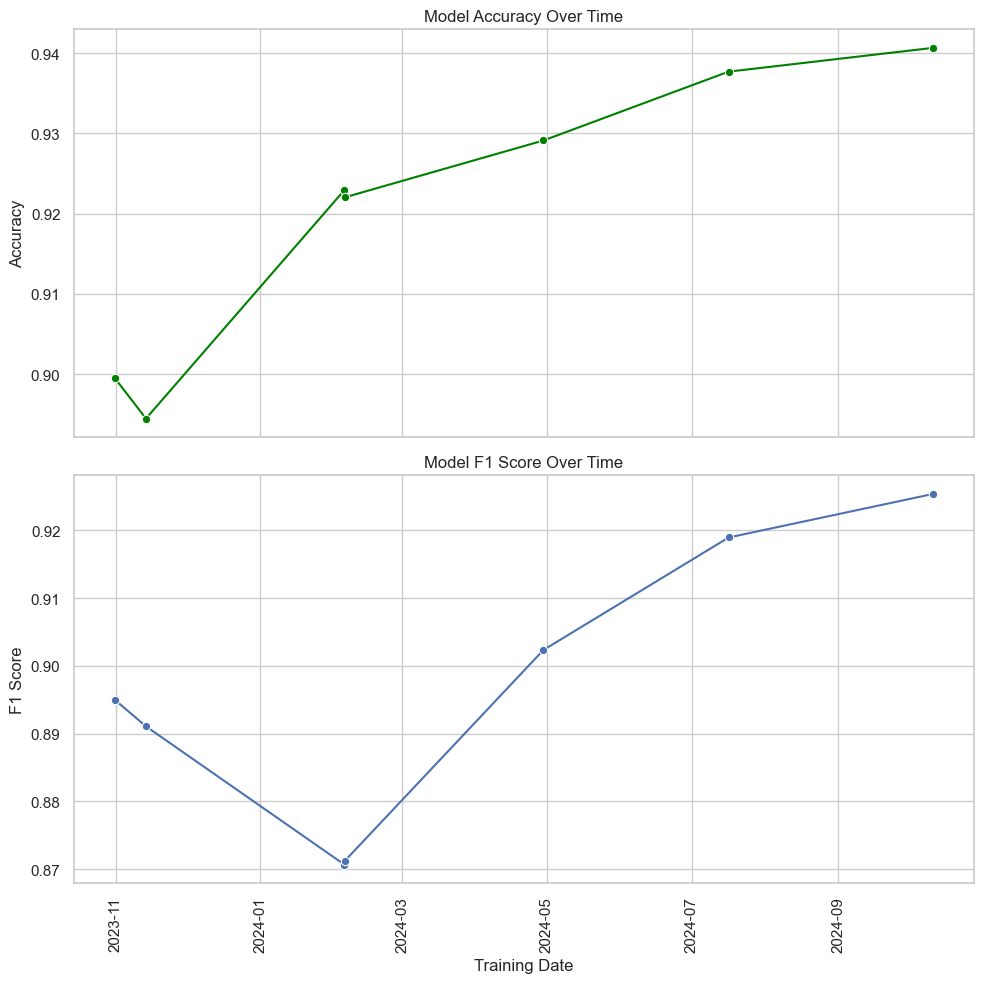

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
data = mod
df = pd.DataFrame(data)
df['Training_Date'] = pd.to_datetime(df['Training_Date'])

# Set the style
sns.set(style="whitegrid")

# Create the figure and axes
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot for Accuracy
sns.lineplot(x='Training_Date', y='Accuracy', data=df, ax=ax[0], marker='o',color = 'green')
ax[0].set_title('Model Accuracy Over Time')
ax[0].set_ylabel('Accuracy')

# Plot for F1 Score
sns.lineplot(x='Training_Date', y='F1_Score', data=df, ax=ax[1], marker='o')
ax[1].set_title('Model F1 Score Over Time')
ax[1].set_ylabel('F1 Score')


# Formatting the x-axis
plt.xlabel('Training Date')
plt.xticks(rotation = 90)

plt.tight_layout()
plt.show()
